<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>


**CONTESTO:** *Fatal Police Shooting in the US*

L’omicidio del 2014 di Michael Brown a Ferguson, Missouri, ha dato origine a una protesta culminata nel movimento Black Lives Matter e al crescente interesse dell’opinione pubblica sull’affidabilità e il razzismo delle forze di polizia negli Stati Uniti.

Il Washington Post compila, da gennaio 2015, un database di tutti i casi di omicidio (da arma da fuoco) da parte della polizia negli Stati Uniti. A questo link (https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us) trovi un dataset pubblico di Kaggle che riporta, oltre a quello del Post, altri quattro database di informazioni demografiche. Il dataset di Kaggle si riferisce al periodo 2015-2016: a questo link (https://github.com/washingtonpost/data-police-shootings) trovi il database del Post aggiornato.

Infine, ecco un database (https://drive.google.com/file/d/1kEikaWCZYVO3ygVvAuVqxYqQPaVJrdYb/view) con la popolazione delle città USA.

**OBIETTIVO:** Analizzerai i dati inerenti ai casi di omicidio (da arma da fuoco) da parte della polizia negli Stati Uniti con lo scopo di evidenziare possibili bias razziali da parte della polizia.

A partire dai dati forniti ti sembra che la polizia americana uccida spoporzionatamente persone appartenenti ad un dato gruppo
prensente nella colonna 'race'?

**NOTA BENE:** Il lavoro va consegnato tenendo a mente che il notebook di Jupyter deve essere simile ad una presentazione da mostrare ad un ipotetico cliente: evitare notebook che siano troppo prolissi e ripetitivi nelle analisi. Scegliere cosa mostrare e perché mostrare quel concetto rispetto ad un altro è una delle capacità da sviluppare per questo workshop

## Exploratory data analysis

Importo le librerie e i dataframes

In [46]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.offline as po
import plotly.express as px


pd.set_option('display.max_rows', 2536)

Carico i datasets

In [47]:
police_killings_df = pd.read_csv("fatal-police-shootings-data.csv")
share_race_by_city = pd.read_csv("ShareRaceByCity.csv")
population_by_city = pd.read_csv("PopulationByCity.csv")
poverty_rate_by_city = pd.read_csv("PercentagePeopleBelowPovertyLevel.csv", encoding='Windows-1252')

### Otteniamo la percentuale (in proporzione di ogni gruppo etnico) delle uccisioni dagli agenti di polizia statunitensi (quindi in tutti gli USA) per ogni stato.

1) Ottengo, tramite join tra shareracebycity e populationbycity, un dataframe con lo share race per ogni stato.

2) Faccio un join per prendere solamente gli stati di interesse (solo quelli in cui sono avvenuti omicidi da police officers).

3) Trasformo le percentuali parziali (delle città) in percentuali globali (per gli stati).

4) Faccio la somma di tutti i decessi per categoria "race" (con un groupby)

5) Li normalizzo con le percentuiali globali ottenute al punto (3)

6) Faccio un barplot che mi indica la presenza di bias razziali sui quali continuare a lavorare

In [48]:
#0.1 Elimino tutte le righe con (X) nel dataframe shareracebycity

share_race_by_city = share_race_by_city[share_race_by_city.B != '(X)']

#0.2 Elimino l'informazione relativa alla tipologia di citta nel dataset ShareByCity

share_race_by_city.city = share_race_by_city.city.str.split().str[:-1].str.join(' ')

#0.3 Elimino le colonne relative alla longitudine e alla latitudine dal dataframe population_by_city

population_by_city.drop(["lat", "lng"], axis=1, inplace=True)

In [49]:
# 0.1 creo la funzione di aggregazione per le percentuali delle etnie

def percentage_aggregation(x):

    population_sum = x.population.sum()

    W = []
    B = []
    N = []
    A = []
    H = []

    for index, row in x.iterrows():
        W.append(float(row.W)*row.population)
        B.append(float(row.B)*row.population)
        N.append(float(row.N)*row.population)
        A.append(float(row.A)*row.population)
        H.append(float(row.H)*row.population)
        
    w = sum(W)/population_sum
    b = sum(B)/population_sum
    n = sum(N)/population_sum
    a = sum(A)/population_sum
    h = sum(H)/population_sum

    return pd.Series([x.state.unique()[0], w, b, n, a, h, population_sum], index=["state", "W", "B", "N", "A", "H", "population"])

In [50]:
share_race_by_city.loc[share_race_by_city.state == "DC", "city"] = "Washington"

In [51]:
# 1 Ottengo gli stati di interesse con un join tra population e share_race_by_city

share_race_by_city = pd.merge(share_race_by_city, population_by_city)

In [52]:
#2 Ottengo l'array contenente solo gli stati di interesse

states = pd.Series(police_killings_df.state.unique(), name='state')

#Faccio il join con ShareRaceByCity

share_race_by_city = pd.merge(share_race_by_city, states)

In [53]:
# 3 Ottengo le sharerace per stato partendo da quelle per città dopo aver aggiunto la popolazione 

share_race_by_state = share_race_by_city[["state", "W", "B", "N", "A", "H", "population"]].groupby("state").apply(percentage_aggregation)
share_race_by_state.reset_index(drop = True, inplace = True)

In [54]:
#4 Faccio la somma degli omicidi per race e stato
police_killing_race_count = police_killings_df[["state", "race"]].dropna()
police_killing_race_count["count"] = 0
police_killing_race_count = police_killing_race_count.groupby(["state", "race"]).count().reset_index()

In [55]:
# Creo un dizionario (con chiave lo stato) di dizionari (con chiavi le race e valori il count)

bins = dict()

for index, row in police_killing_race_count.iterrows():

    if row.state in bins:
        bins[row.state][row.race] = row["count"]
    else:
        bins[row.state] = dict()
        bins[row.state][row.race] = row["count"]

# Mi assicuro che ogni race abbia un valore
for k in bins.keys():

    if "A" not in bins[k].keys():
        bins[k]["A"] = 0
    if "B" not in bins[k].keys():
        bins[k]["B"] = 0
    if "W" not in bins[k].keys():
        bins[k]["W"] = 0
    if "H" not in bins[k].keys():
        bins[k]["H"] = 0
    if "N" not in bins[k].keys():
        bins[k]["N"] = 0
    if "O" not in bins[k].keys():
        bins[k]["O"] = 0

In [56]:
#Creo un dizionario delle popolazioni per stato

state_pop_race = dict()

for index, row in share_race_by_state.iterrows():
    state_pop_race[row.state] = {"population":row.population, 
                                "W": row.W, 
                                "B": row.B, 
                                "N": row.N, 
                                "A": row.A, 
                                "H": row.H
                                }

Creo delle liste dove vado ad inserire le percentuali di uccisioni (rapportate alle percentuali di razza per stato)

In [57]:
W_y = [bins[x]["W"]*(10**6)/(state_pop_race[x]["population"]*state_pop_race[x]["W"]) for x in share_race_by_state.state]
B_y = [bins[x]["B"]*(10**6)/(state_pop_race[x]["population"]*state_pop_race[x]["B"]) for x in share_race_by_state.state]
N_y = [bins[x]["N"]*(10**6)/(state_pop_race[x]["population"]*state_pop_race[x]["N"]) for x in share_race_by_state.state]
A_y = [bins[x]["A"]*(10**6)/(state_pop_race[x]["population"]*state_pop_race[x]["A"]) for x in share_race_by_state.state]
H_y = [bins[x]["H"]*(10**6)/(state_pop_race[x]["population"]*state_pop_race[x]["H"]) for x in share_race_by_state.state]

states = list(share_race_by_state.state)

In [58]:
plt.rcParams["figure.figsize"] = (20, 5)

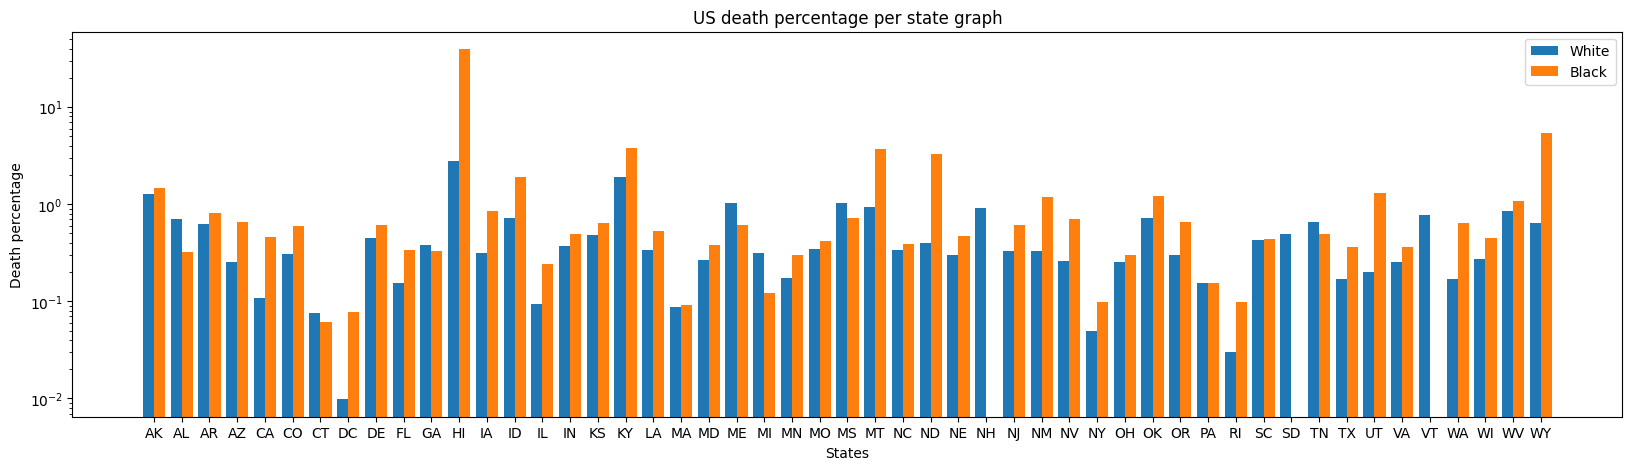

In [59]:
X_axis = np.arange(len(states))
  
plt.bar(X_axis - 0.2, W_y, 0.4, label = 'White')
plt.bar(X_axis + 0.2, B_y, 0.4, label = 'Black')

plt.yscale("log")

plt.xticks(X_axis, states)
plt.xlabel("States")
plt.ylabel("Death percentage")
plt.title("US death percentage per state graph")
plt.legend()
plt.savefig('Death percentage.png', bbox_inches = 'tight', dpi=300)
plt.show()

In [60]:
# Prendo gli stati con più uccisioni (in proporzione) di neri

black_bias_state = [x for i, x in enumerate(states) if B_y[i] > W_y[i]]
black_bias_black = [B_y[i] for i, x in enumerate(states) if B_y[i] > W_y[i]]
black_bias_white = [W_y[i] for i, x in enumerate(states) if B_y[i] > W_y[i]]

# Prendo gli stati con più uccisioni (in proporzione) di bianchi

white_bias_state = [x for i, x in enumerate(states) if W_y[i] > B_y[i]]
white_bias_black = [B_y[i] for i, x in enumerate(states) if W_y[i] > B_y[i]]
white_bias_white = [W_y[i] for i, x in enumerate(states) if W_y[i] > B_y[i]]

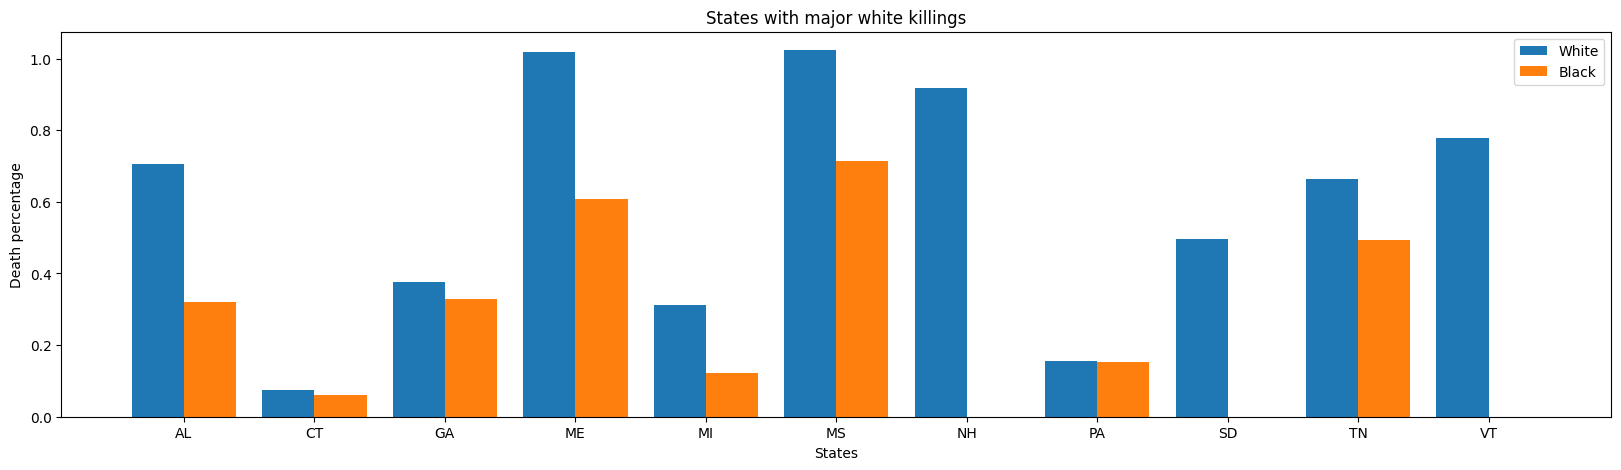

In [61]:
# Plot degli stati dove la percentuale (in proporzione) di uccisioni bianche è maggiore di quella delle uccisioni nere
X_axis = np.arange(len(white_bias_state))
  
plt.bar(X_axis - 0.2, white_bias_white, 0.4, label = 'White')
plt.bar(X_axis + 0.2, white_bias_black, 0.4, label = 'Black')

plt.xticks(X_axis, white_bias_state)
plt.xlabel("States")
plt.ylabel("Death percentage")
plt.title("States with major white killings")
plt.legend()
plt.savefig('White death percentage.png', bbox_inches = 'tight', dpi=300)
plt.show()

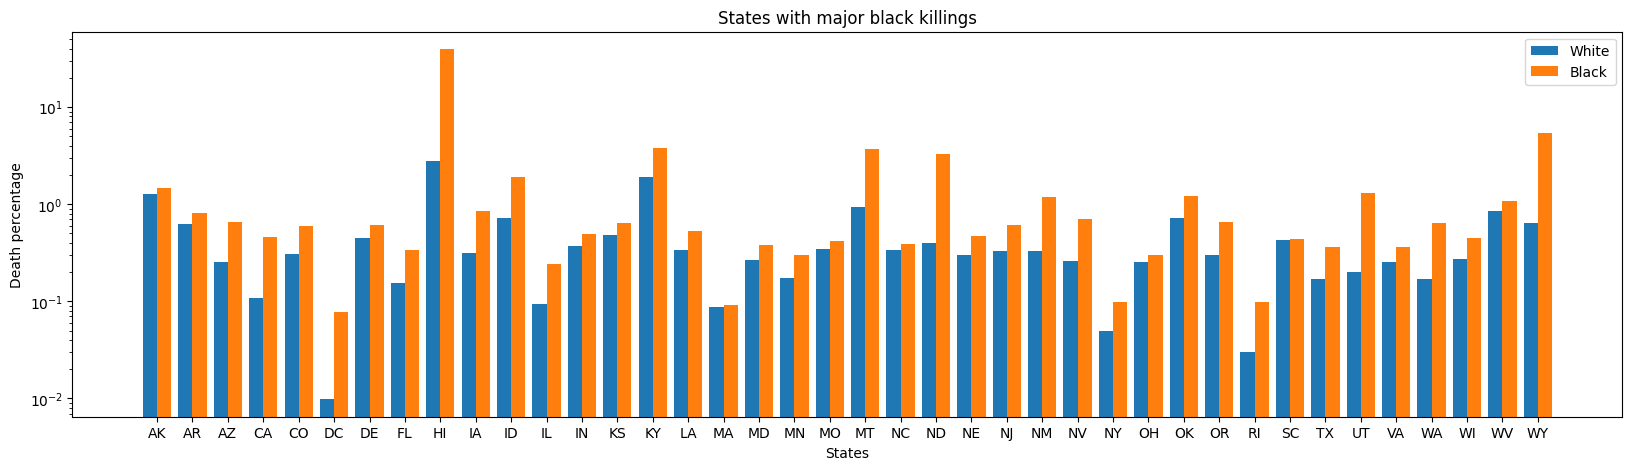

In [62]:
# Plot degli stati dove la percentuale (in proporzione) di uccisioni nere è maggiore di quella delle uccisioni bianche
X_axis = np.arange(len(black_bias_state))
  
plt.bar(X_axis - 0.2, black_bias_white, 0.4, label = 'White')
plt.bar(X_axis + 0.2, black_bias_black, 0.4, label = 'Black')

plt.xticks(X_axis, black_bias_state)
plt.xlabel("States")
plt.ylabel("Death percentage")

plt.yscale("log")

plt.title("States with major black killings")
plt.legend()
plt.savefig('Black death percentage.png', bbox_inches = 'tight', dpi=300)
plt.show()

Ora andiamo a vedere le differenze in termini di poverty share dei due insiemi di stati

In [63]:
# Ottengo il nome assoluto delle città

poverty_rate_by_city.city = poverty_rate_by_city.city.str.split().str[:-1].str.join(' ')
poverty_rate_by_city.loc[poverty_rate_by_city.state == "DC", "city"] = "Washington"

Ora, dal dataframe poverty_rate_by_city, derivo il dataframe poverty_rate_by_state

In [64]:
def percentage_aggregation_poverty_bydf(x):

    population_sum = x.population.sum()

    PR = []

    for index, row in x.iterrows():
        PR.append(float(row.poverty_rate)*row.population)
        
    poverty_rate = sum(PR)/population_sum
    

    return pd.Series([poverty_rate, population_sum], index=["poverty_rate", "population"])
    

In [65]:
city_poverty_pop = pd.merge(poverty_rate_by_city, population_by_city)

In [66]:
def percentage_aggregation_poverty(x):

    population_sum = x.population.sum()

    PR = []

    for index, row in x.iterrows():
        PR.append(float(row.poverty_rate)*row.population)
        
    poverty_rate = sum(PR)/population_sum
    

    return pd.Series([x.state.unique()[0], poverty_rate, population_sum], index=["state", "poverty_rate", "population"])
    

In [67]:
state_poverty_pop = city_poverty_pop.groupby("state").apply(percentage_aggregation_poverty)
state_poverty_pop.reset_index(drop = True, inplace = True)
poverty_share = np.array(state_poverty_pop.poverty_rate)

In [68]:
state_poverty_pop.head()

,state,poverty_rate,population
0,AK,9.443394,353942.0
1,AL,23.703431,2700398.0
2,AR,21.482814,1570573.0
3,AZ,20.118335,8225324.0
4,CA,17.968445,49197568.0


In [69]:
poverty_rate_by_white_bias = percentage_aggregation_poverty_bydf(state_poverty_pop[state_poverty_pop.state.isin(white_bias_state)])
poverty_rate_by_black_bias = percentage_aggregation_poverty_bydf(state_poverty_pop[state_poverty_pop.state.isin(black_bias_state)])

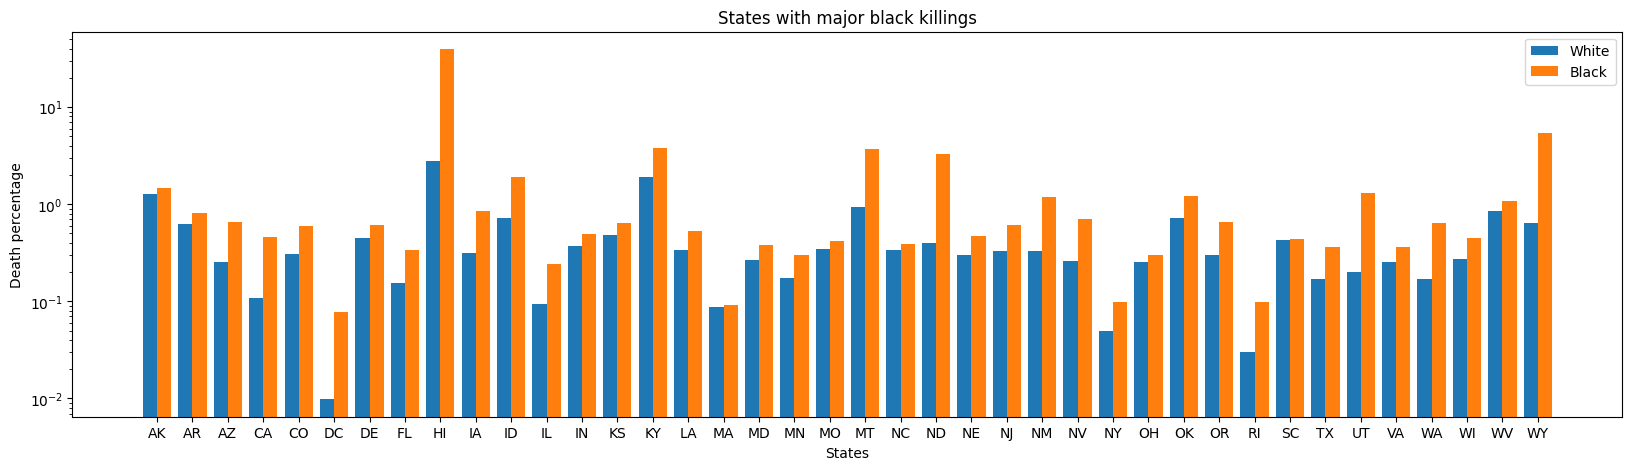

In [70]:
# Plot degli stati dove la percentuale (in proporzione) di uccisioni nere è maggiore di quella delle uccisioni bianche
X_axis = np.arange(len(black_bias_state))
  
plt.bar(X_axis - 0.2, black_bias_white, 0.4, label = 'White')
plt.bar(X_axis + 0.2, black_bias_black, 0.4, label = 'Black')

plt.xticks(X_axis, black_bias_state)
plt.xlabel("States")
plt.ylabel("Death percentage")

plt.yscale("log")

plt.title("States with major black killings")
plt.legend()
plt.savefig('Black death percentage.png', bbox_inches = 'tight', dpi=300)
plt.show()

In [71]:
# Grafico degli stati per le uccisioni nere
data = dict(type='choropleth', 
            locations = black_bias_state,
            locationmode = 'USA-states',
            colorscale = 'bluyl',
            z = black_bias_black)
layout = dict(geo = {'scope':'usa'}, autosize = True)

x = go.Figure(data = [data], layout = layout)
po.iplot(x)

### Grafico delle percentuali delle race stato per stato

In [72]:
fig = px.bar(share_race_by_state.drop(columns="population"), x="state", y=["W", "B","A","H","N"], title="Race percentage over states")
fig.show()

### Inserire grafico delle uccisioni per età

In [73]:
fig = px.strip(police_killings_df.age, x='age',title='Police Killings by Age' ,color_discrete_sequence= ["blue"])
fig.show()

### Controllo se è presente una correlazione tra il livello di poverta e la killing_rate

In [74]:
# states: lista degli stati di interesse
# W_y: lista delle percentuali per stato di uccisioni bianche rapportate alla sharerace by state
# B_y: lista delle percentuali per stato di uccisioni nere rapportate alla sharerace by state


Ora, dal dataframe poverty_rate_by_city, derivo il dataframe poverty_rate_by_state

In [75]:
killing_count = np.array(police_killings_df[police_killings_df.state.isin(states)].groupby("state").count().id)

In [76]:
killing_sort = killing_count.argsort()
killing_count.sort()

In [77]:
poverty_share = np.take_along_axis(poverty_share, killing_sort, axis=0)


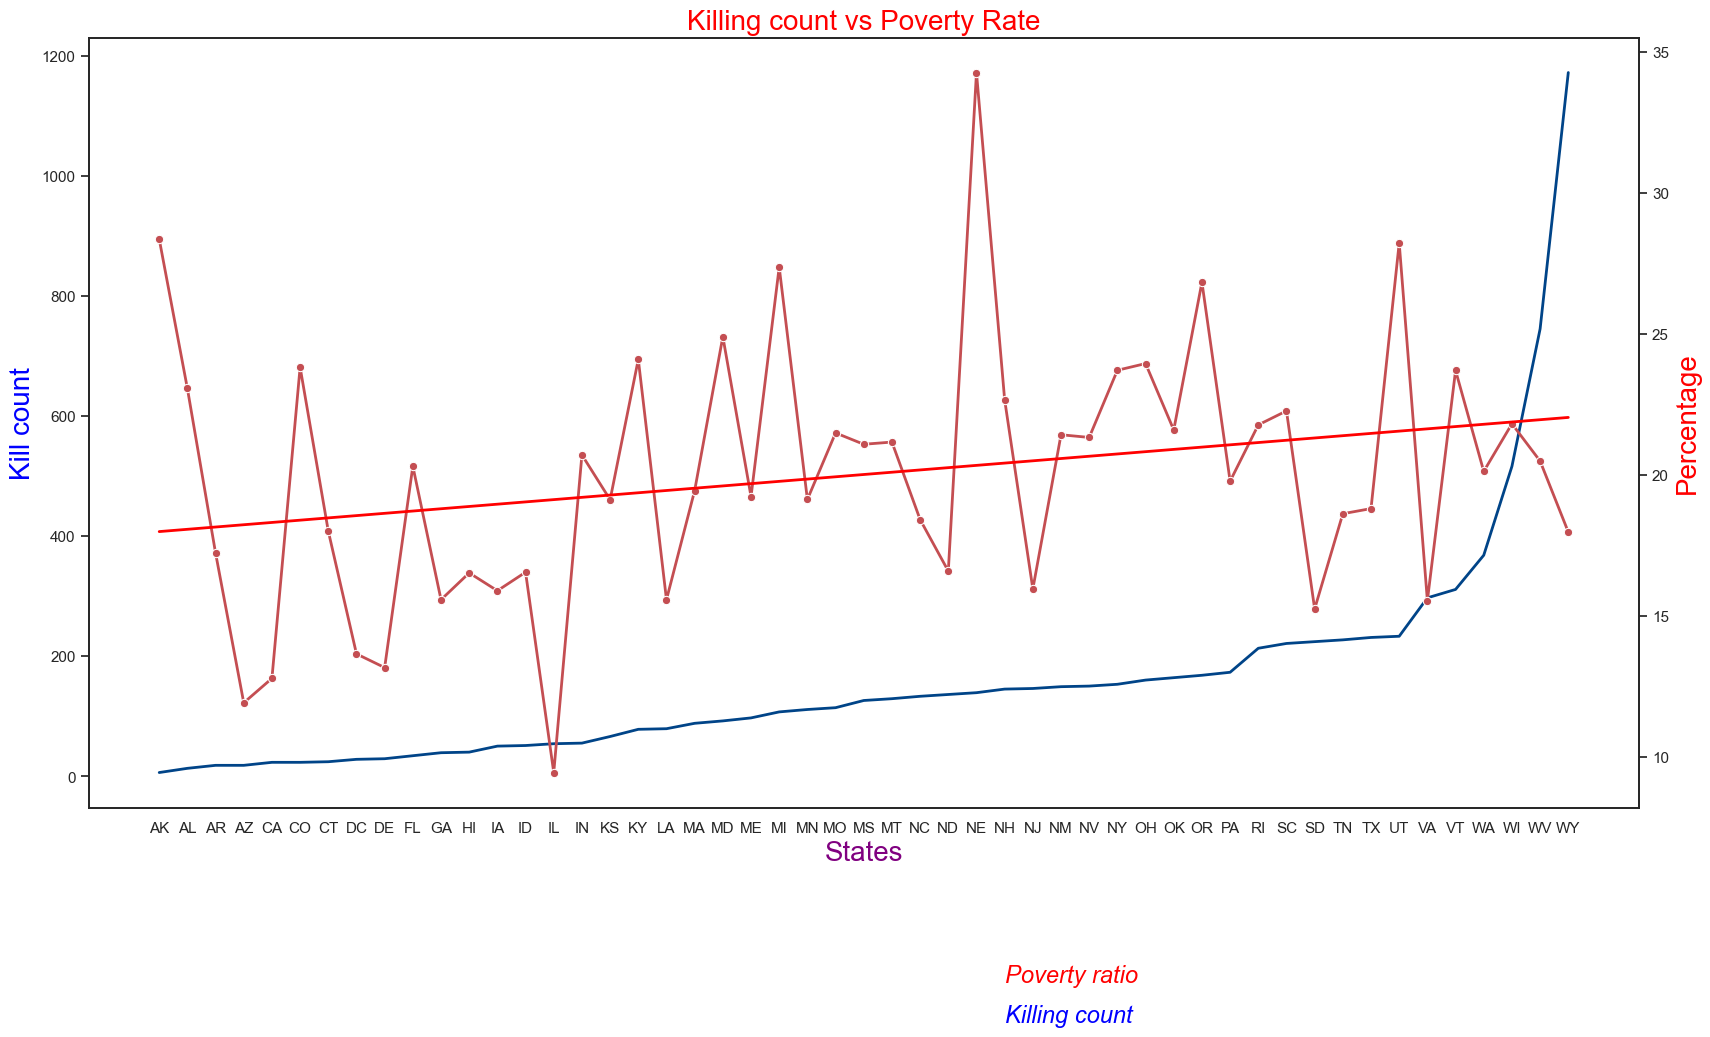

In [78]:
import seaborn as sns
sns.set(style="white", rc={"lines.linewidth": 2, 'figure.figsize':(95,88)})

f,ax1 = plt.subplots(figsize = (20,10))

#Trovo la bestfit line della poverty_share

m, q = np.polyfit(range(len(states)), poverty_share, 1)

ax2 = ax1.twinx()
sns.lineplot(x=states,
            y=killing_count, 
            color='#004488',
            ax=ax1)
sns.lineplot(x=states,
            y=poverty_share, 
            color='r',
             marker="o",
            ax=ax2)
plt.plot(states, [m*i + q for i in range(len(states))], color='red')

ax1.set_xlabel("States", fontsize = 20 , color = "purple")
ax1.set_ylabel("Kill count",fontsize = 20, color = "blue")
ax2.set_ylabel("Percentage",fontsize = 20, color = "red")
plt.title("Killing count vs Poverty Rate",fontsize = 20 , color = "red")
plt.text(30,0.6,"Killing count",color = "blue" , fontsize = 17, style = "italic")
plt.text(30,2, "Poverty ratio" , color = "red" , fontsize = 17 , style = "italic")

plt.show()